In [2]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

from modules import solver, presolver
from pyballistics import ozvb_lagrange, get_db_powder, get_powder_names
from joblib import Parallel, delayed
from matplotlib import cm
from matplotlib.colors import ListedColormap


## Визуализация решения обратной задачи

In [53]:
table_obr = pd.read_csv("data/table_result_lenght.csv")

In [79]:
table_obr.sort_values(by=['mass'])

,name,succes,wq,ro,mass,reason
63,МАП-1 23/1,True,1.178537,737.374805,898.155705,v_p
59,АПЦ-235 П 16/1,True,1.263600,791.626858,934.885072,v_p
64,БНГ-1355 25/1,True,1.326195,838.394651,949.439067,v_p
58,16/1 тр,True,1.992176,546.042434,951.565176,v_p
56,18/1 тр,True,1.270173,824.618552,956.647685,v_p
...,...,...,...,...,...,...
6,5/1,True,1.746611,366.578234,3697.111870,x_p
5,ВТМ,True,1.738955,364.517064,3800.703745,x_p
4,ВТ,True,1.692965,365.595023,3842.994861,x_p
2,ВУ фл,True,1.653130,364.103091,3998.733872,x_p


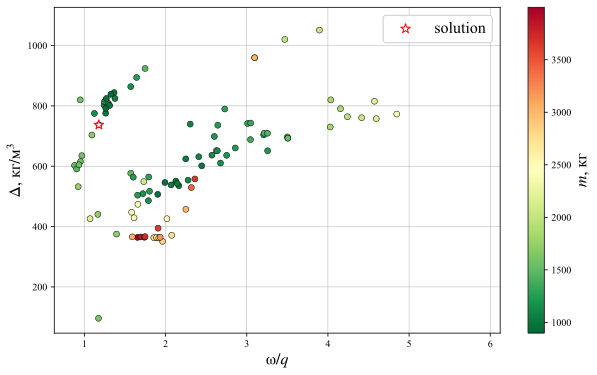

In [76]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
fs = 16
fig = plt.figure(figsize=(10,6), dpi=300)

fig3 = plt.scatter(table_obr['wq'], table_obr['ro'], c=table_obr['mass'], cmap='RdYlGn_r', 
                   edgecolors='black', linewidths=0.5, zorder = 3)

plt.scatter(1.178, 737, color='white', marker='*', edgecolors='red', s=100, linewidths=1, zorder = 3, label='solution')

plt.legend(fontsize=16, loc='upper right', framealpha=1)
bar = plt.colorbar(fig3)
bar.ax.set_ylabel(r'$m$, кг', fontsize=fs)
plt.xlabel(r'$\mathrm{\omega/\mathit{q}}$',  fontsize = fs)
plt.ylabel('$\mathit{\Delta}$, $\mathrm{кг/м^3}$',  fontsize = fs)
plt.grid(linewidth=0.5)
plt.show()

## Прямая задача

In [19]:
d = 125*1e-3
name = "МАП-1 23/1"
wq_0, ro_0 = 1.178537, 737.374805

In [6]:
table = pd.read_csv("data/direct_task.csv")

In [7]:
table[table['reason']=='v_p']['mass']

29      2482.409920
31      1042.770985
34       903.266648
40      1248.418039
44      1513.162307
           ...     
9944    1161.499208
9958    1051.483212
9976    3009.663457
9989    1263.014470
9991    1018.988273
Name: mass, Length: 1357, dtype: float64

In [8]:
Bluemap = cm.get_cmap('Blues', 1024)

newcolors = Bluemap(np.linspace(0, 1,1024))
newcolors[950:1024:, :] = cm.get_cmap('RdYlGn_r', 400)(np.linspace(0.0, 1, 74))[:74]
newcmpRdy = ListedColormap(newcolors[::-1])

C:\Users\Maksim\AppData\Local\Temp/ipykernel_33812/287923176.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = table[table['reason']=='v_p'][table['mass'] < treshold]['wq']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_33812/287923176.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = table[table['reason']=='v_p'][table['mass'] < treshold]['ro']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_33812/287923176.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col = table[table['reason']=='v_p'][table['mass'] < treshold]['mass']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_33812/287923176.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = table[table['reason']=='v_p'][table['mass'] >= treshold]['wq']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_33812/287923176.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

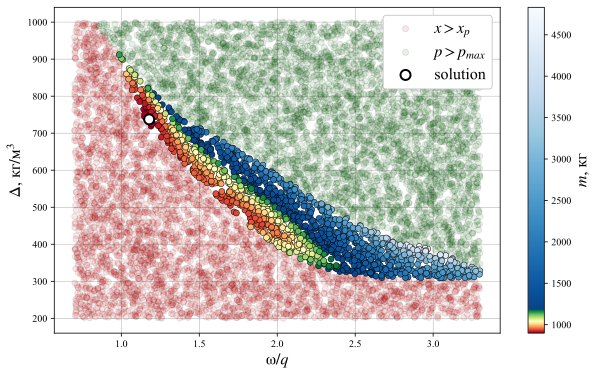

In [45]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
fs = 16
fig = plt.figure(figsize=(10,6), dpi=300)

norm = mpl.colors.Normalize(vmin=500, vmax=4000)

treshold = 5000

x = table[table['reason']=='v_p'][table['mass'] < treshold]['wq']
y = table[table['reason']=='v_p'][table['mass'] < treshold]['ro']
col = table[table['reason']=='v_p'][table['mass'] < treshold]['mass']

x1 = table[table['reason']=='v_p'][table['mass'] >= treshold]['wq']
y1 = table[table['reason']=='v_p'][table['mass'] >= treshold]['ro']

plt.scatter(table[table['reason']=='x_p']['wq'], table[table['reason']=='x_p']['ro'],\
            color='red', edgecolors='black', linewidths=1, zorder = 3, alpha=0.1, label=r'$x > x_{p}$')
plt.scatter(table[table['reason']=='p_max']['wq'], table[table['reason']=='p_max']['ro'],\
            color='green', edgecolors='black', linewidths=1, zorder = 3, alpha=0.1, label=r'$p > p_{max}$')

fig3 = plt.scatter(x, y, c=col, cmap=newcmpRdy, edgecolors='black', linewidths=0.5, zorder = 3)
#plt.scatter(x1, y1, c='yellow', edgecolors='black', linewidths=0.5, zorder = 3)

plt.scatter(wq_0, ro_0, color='white', edgecolors='black', s=100, linewidths=2, zorder = 3, label='solution')

plt.legend(fontsize=16, loc='upper right', framealpha=1)
bar = plt.colorbar(fig3)
bar.ax.set_ylabel(r'$m$, кг', fontsize=fs)
plt.xlabel(r'$\mathrm{\omega/\mathit{q}}$',  fontsize = fs)
plt.ylabel('$\mathit{\Delta}$, $\mathrm{кг/м^3}$',  fontsize = fs)
plt.grid(linewidth=0.5)
plt.show()

In [46]:
#fig.savefig('data/bananas.jpg', dpi = 400, pad_inches=10)

### Ствол

In [20]:
result = ozvb_lagrange(presolver.init_dict(name, wq_0, ro_0))

In [21]:
matrix_p = solver.Solver.make_matrix(result, 'p')
matrix_x = solver.Solver.make_matrix(result, 'x')

In [22]:
#add layre to 'p' for shape alignment with 'x'
matrix_p = np.row_stack((matrix_p.T, matrix_p.T[-1])).T
#calculate coordinate from 0 point
l0 = np.abs(matrix_x[0][0])
matrix_x += np.abs(matrix_x[0][0])

In [23]:
cannon = solver.Cannon(0.125, matrix_x, matrix_p, l0)

In [24]:
cannon.cannon_geometry()

#### Распределение давления

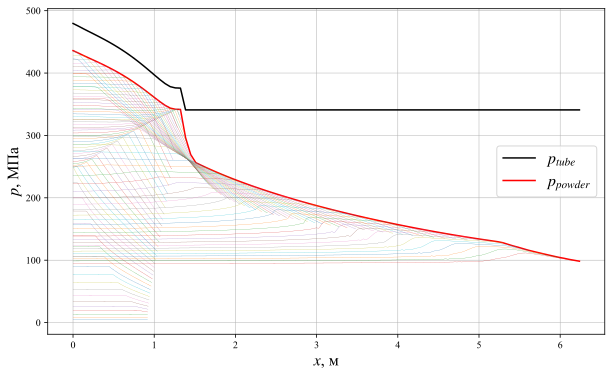

In [48]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif",
        "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
#matplotlib.rcParams.update({'font.size': 17})
#plt.rcParams["font.family"] = "Times New Roman"

fs = 16
fig = plt.figure(figsize=(10,6), dpi=300)
plt.plot(cannon.coordinate, cannon.pressure_tube/1e6, color='black', label='$p_{tube}$')
plt.plot(cannon.coordinate, cannon.pressure/1e6, color='red', label='$p_{powder}$')

for i in range(0 ,matrix_p.shape[0], 20):
    plt.plot(matrix_x[i], matrix_p[i]/1e6, linewidth=0.2)

plt.legend(fontsize=fs, loc = 'center right')
plt.xlabel(r'$x$, м',  fontsize=fs)
plt.ylabel(r'$p$, МПа',  fontsize=fs)
plt.grid(linewidth=0.5)
plt.show()

In [49]:
fig.savefig('data/pressure.jpg', dpi = 400, pad_inches=10)

#### Геометрия

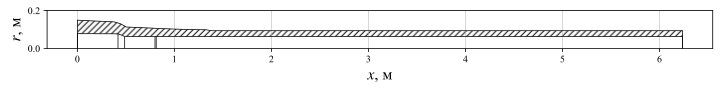

In [50]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

fs = 16
width = 0.75
fig = plt.figure(figsize=(12,0.7), dpi=300)
plt.plot(cannon.coordinate, cannon.r_outside, color='black', linewidth=width)
plt.plot(cannon.r_inside_coordinate, cannon.r_inside, color='black', linewidth=width)

for i in range(len(cannon.r_inside_coordinate)):
    plt.vlines(x=cannon.r_inside_coordinate[i], ymin=0, ymax=cannon.r_inside[i], color='black', linewidth=width)
    
plt.vlines(cannon.r_inside_coordinate[0], 0, cannon.r_outside[0], color='black', linewidth=width)
plt.vlines(cannon.r_inside_coordinate[-1], 0, cannon.r_outside[-1], color='black', linewidth=width)

plt.fill_between(cannon.coordinate, np.interp(cannon.coordinate, cannon.r_inside_coordinate, cannon.r_inside),
                 cannon.r_outside, facecolor="white", hatch="////")

plt.ylim(0, 0.2)
plt.xlabel(r'$x$, м',  fontsize=fs)
plt.ylabel(r'$r$, м',  fontsize=fs)
plt.grid(linewidth=0.5)
plt.show()

In [51]:
fig.savefig('data/geometry.jpg', dpi = 400, pad_inches=10)

In [26]:
cannon.get_mass()

911.3320641311786

In [27]:
cannon.coordinate[-1]

6.237105644864589